In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

from sklearn.metrics import confusion_matrix

def confusion_matrix_plt(model, X, y_true):
    y_pred = model.predict(X)
    
    fig, ax = plt.subplots(figsize = (12, 6))
    
    plt.title("Normalizirana matrica zbunjenosti")
    sns.heatmap(
        confusion_matrix(y_true, y_pred, normalize = "true"),
        annot = True,
        cmap = "Greens",
        fmt = ".2f",
    ).set(xlabel = "predviđeno", ylabel = "stvarno")

RANDOM_STATE = 3

# **Sređivanje podataka**

In [2]:
podaci = pd.read_csv("input/credit-risk-dataset/credit_risk_dataset.csv").rename(
    columns = {"loan_status": "default"}
)
podaci["cb_person_default_on_file"] = podaci["cb_person_default_on_file"].replace({'N': 0, 'Y': 1})
podaci.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,default,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,1,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,0,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,0,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,0,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,1,4


In [3]:
podaci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   default                     32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  int64  
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 3.0+ MB


In [4]:
podaci.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
default                          0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [5]:
podaci = podaci.dropna()

In [6]:
podaci.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,default,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
count,28638.000000,2.863800e+04,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000
mean,27.727216,6.664937e+04,4.788672,9656.493121,11.039867,0.216600,0.169488,0.178190,5.793736
std,6.310441,6.235645e+04,4.154627,6329.683361,3.229372,0.411935,0.106393,0.382679,4.038483
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,0.000000,2.000000
25%,23.000000,3.948000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,0.000000,3.000000
50%,26.000000,5.595600e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,0.000000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,0.000000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,1.000000,30.000000


In [7]:
# max(person_age) = 144 (ne znam baš)
podaci = podaci.drop(podaci[podaci["person_age"] > 90].index)
# max(person_emp_length) = 123
podaci = podaci.drop(podaci[podaci["person_emp_length"] > 70].index)

# logaritamska transformacija varijabli koje slijede power law
podaci["person_income"] = np.log(podaci["person_income"])
podaci["loan_amnt"] = np.log(podaci["loan_amnt"])

podaci = podaci.reset_index(drop = True)

podaci.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,default,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
count,28632.000000,28632.000000,28632.000000,28632.000000,28632.000000,28632.000000,28632.000000,28632.000000,28632.000000
mean,27.712140,10.937396,4.780316,8.950353,11.039701,0.216611,0.169489,0.178192,5.793553
std,6.171989,0.557539,4.035616,0.708536,3.229409,0.411942,0.106361,0.382681,4.037133
min,20.000000,8.294050,0.000000,6.214608,5.420000,0.000000,0.000000,0.000000,2.000000
25%,23.000000,10.582941,2.000000,8.517193,7.900000,0.000000,0.090000,0.000000,3.000000
50%,26.000000,10.931320,4.000000,8.987197,10.990000,0.000000,0.150000,0.000000,4.000000
75%,30.000000,11.289782,7.000000,9.433484,13.480000,0.000000,0.230000,0.000000,8.000000
max,84.000000,14.528354,41.000000,10.463103,23.220000,1.000000,0.830000,1.000000,30.000000


<Axes: xlabel='default', ylabel='count'>

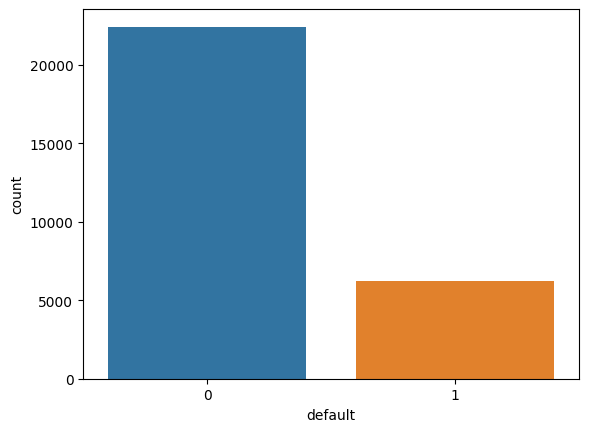

In [8]:
sns.countplot(x = "default", data = podaci)

<Axes: title={'center': 'Matrica korelacije'}>

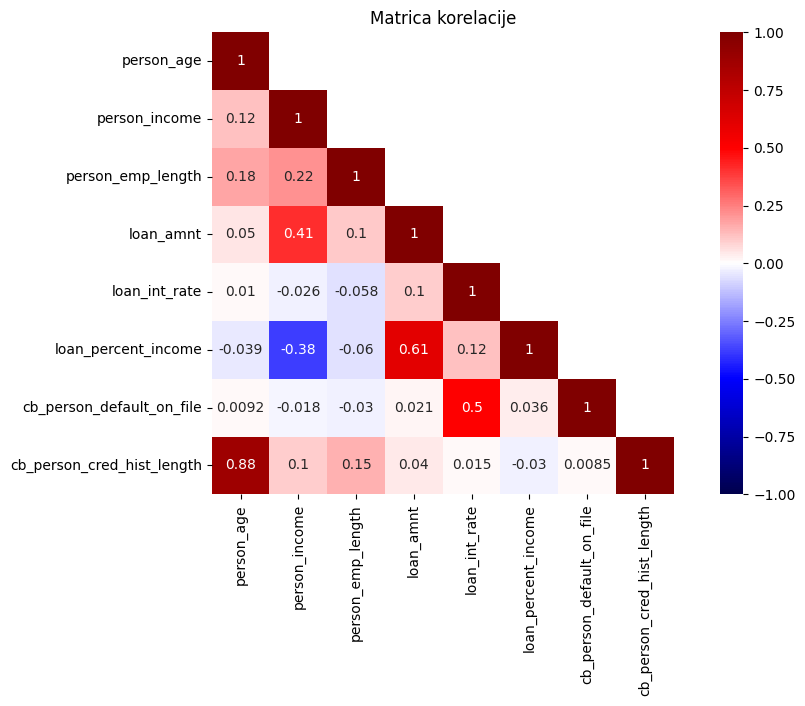

In [9]:
podaci = pd.get_dummies(podaci)

podaci_corr = pd.DataFrame(podaci, columns = [
    "person_age",
    "person_income",
    "person_emp_length",
    "loan_amnt",
    "loan_int_rate",
    "loan_percent_income",
    "cb_person_default_on_file",
    "cb_person_cred_hist_length",
]).corr()

fig, ax = plt.subplots(figsize = (12, 6))
plt.title("Matrica korelacije")
sns.heatmap(
    podaci_corr, 
    square = True, annot = True, 
    vmin = -1, vmax = 1, cmap = "seismic",
    mask = np.triu(podaci_corr, k = 1)
)

In [10]:
X = podaci.drop(["default"], axis = 1) # axis = 1 -> stupci
y = podaci["default"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size = 0.7, stratify = y, 
    random_state = RANDOM_STATE
)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# **Logistička regresija**

In [11]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.8715948777648428

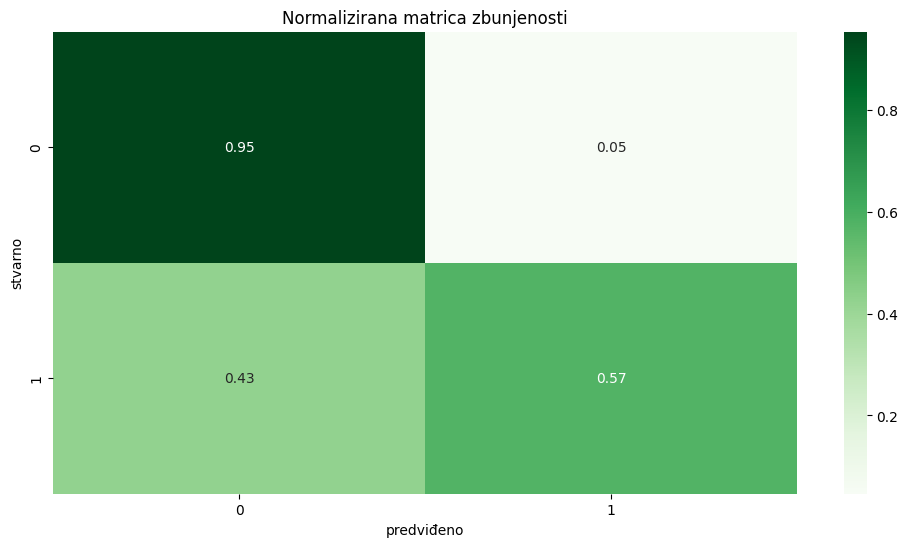

In [12]:
confusion_matrix_plt(log_reg, X_test, y_test)

# **Metoda potpornih vektora (*support vector machine*)**

In [13]:
svc = SVC()
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

#svc_opti = GridSearchCV(svc, {
#    "kernel": ["linear", "poly", "rbf"]
#})
#svc_opti.fit(X_train, y_train)
#svc_opti.best_params_

0.9123399301513387

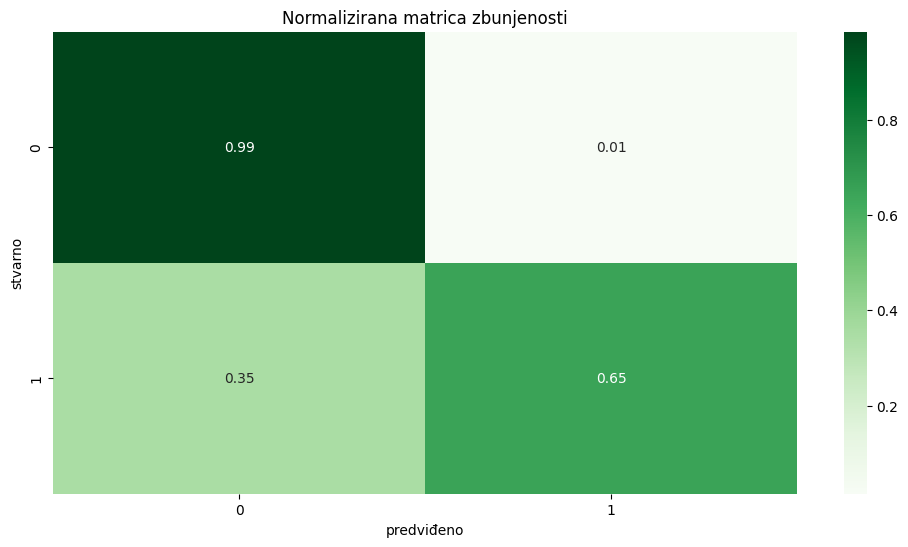

In [14]:
confusion_matrix_plt(svc, X_test, y_test)

# **Stablo odluke (*decision tree*)**

In [15]:
dtc = DecisionTreeClassifier(
    random_state = RANDOM_STATE, 
)
dtc.fit(X_train, y_train)
dtc.score(X_test, y_test)

0.8778812572759022

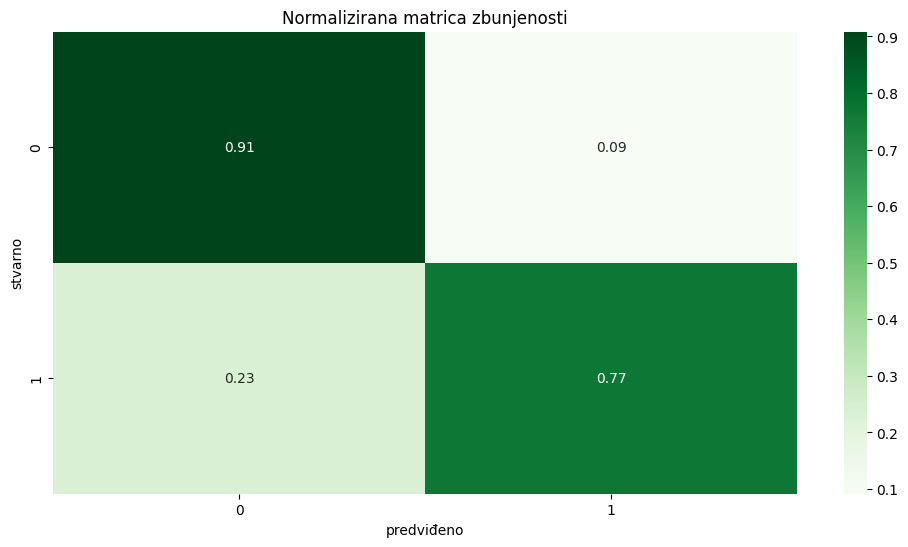

In [16]:
confusion_matrix_plt(dtc, X_test, y_test)

# **Metoda slučajnih šuma (*random forest*)**

In [17]:
rfc = RandomForestClassifier(
    n_estimators = 100,
    random_state = RANDOM_STATE,
)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.9335273573923166

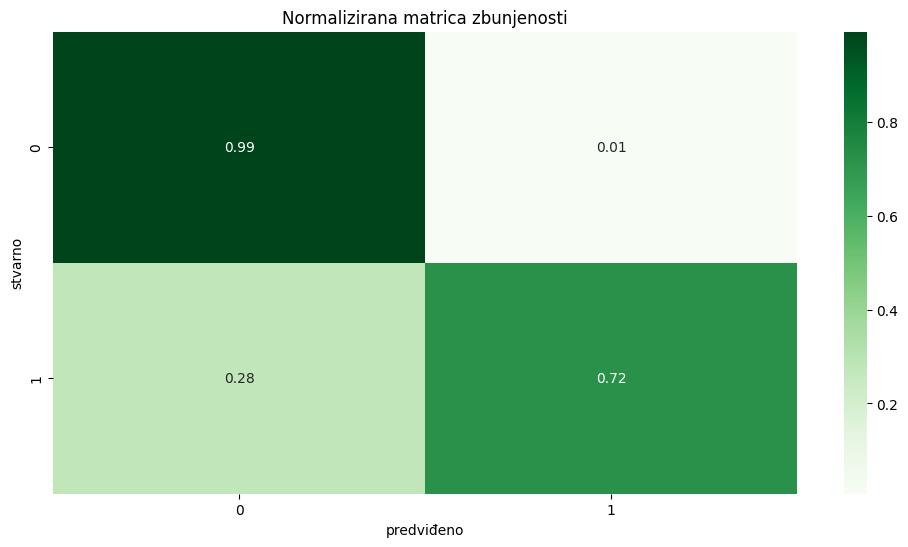

In [18]:
confusion_matrix_plt(rfc, X_test, y_test)

In [19]:
# rfc_cv = cross_val_score(estimator = rfc, X = x_train, y = y_train, cv = 10)
# rfc_cv.mean()

# ***XGBoost***

In [20]:
xgbc = XGBClassifier(
    objective = "binary:logistic", 
    n_estimators = 100,
)
xgbc.fit(X_train, y_train)
xgbc.score(X_test, y_test)

0.9073341094295693

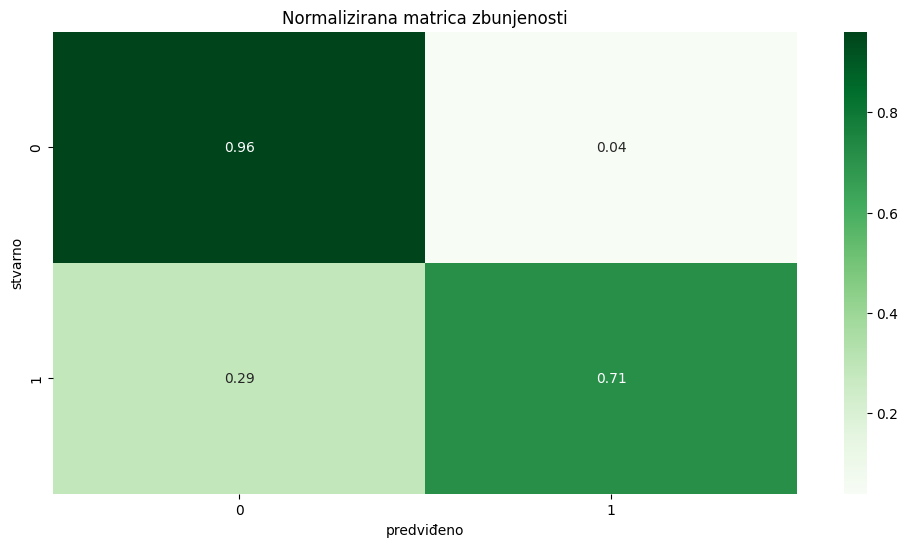

In [21]:
confusion_matrix_plt(xgbc, X_test, y_test)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

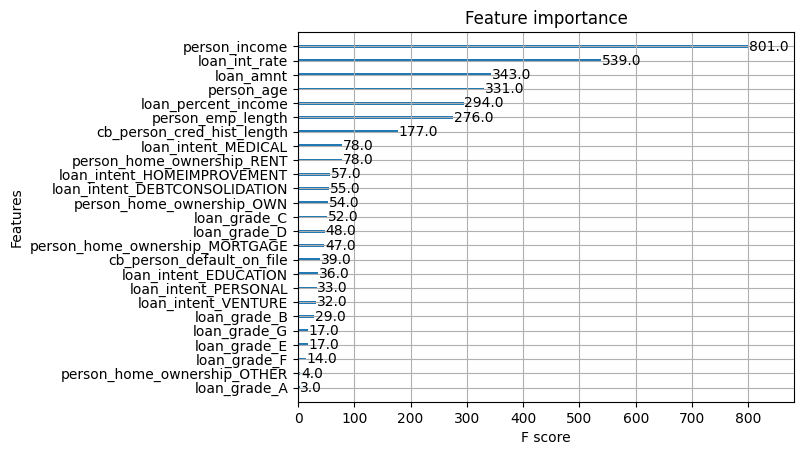

In [22]:
regresori = list(podaci.columns)
regresori.remove("default")
xgbc.get_booster().feature_names = regresori

plot_importance(xgbc)